### Aprendizado de máquina de classificação binária Projeto de estudo de caso

Como você trabalha com um problema de aprendizado de máquina de modelagem preditiva de ponta a ponta? Nisso
lição você trabalhará com um problema de modelagem preditiva de classificação de estudo de caso em Python
incluindo cada etapa do processo de aprendizado de máquina aplicado. Depois de concluir este projeto, você
saberá:

. Como trabalhar com um problema de modelagem preditiva de classificação de ponta a ponta.
. Como usar transformações de dados para melhorar o desempenho do modelo.
. Como usar o ajuste de algoritmo para melhorar o desempenho do modelo.
. Como usar métodos de conjunto e ajuste de métodos de conjunto para melhorar o desempenho do modelo
mance.

#### Definição do Problema

O foco deste projeto será o conjunto de dados Sonar Mines vs Rocks1. O problema é prever
objetos de metal ou rocha dos dados de retorno do sonar. Cada padrão é um conjunto de 60 números no intervalo
0,0 a 1,0. Cada número representa a energia dentro de uma determinada banda de frequência, integrada
durante um determinado período de tempo. O rótulo associado a cada registro contém a letra R se
o objeto é uma rocha e M se for uma mina (cilindro de metal). Os números nas etiquetas estão em
ordem crescente do ângulo de aspecto, mas eles não codificam o ângulo diretamente.

#### Carregar o conjunto de dados

Vamos começar carregando as bibliotecas necessárias para este projeto.

In [1]:
# Load libraries
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

Você pode baixar o conjunto de dados do site do repositório UCI Machine Learning2 e salvar
no diretório de trabalho local com o nome de arquivo sonar.all-data.csv.

In [2]:
# Load dataset
url = 'datasets/sonar.all-data.csv'
dataset = read_csv(url, header=None)

Você pode ver que não estamos especificando os nomes dos atributos desta vez. Isto é porque
além do atributo de classe (a última coluna), as variáveis não possuem nomes significativos.
Também indicamos que não há informações de cabeçalho, isso é para evitar que o código de carregamento do arquivo leve o
primeiro registro como os nomes das colunas. Agora que carregamos o conjunto de dados, podemos dar uma olhada nele.

#### Analisar dados

Vamos dar uma olhada em nossos dados carregados.

#### Estatísticas descritivas

Começaremos confirmando as dimensões do conjunto de dados, por ex. o número de linhas e
colunas.

In [3]:
# shape
print(dataset.shape)

(208, 61)


Temos 208 instâncias para trabalhar e podemos confirmar que os dados têm 61 atributos, incluindo
o atributo de classe.

Vejamos também os tipos de dados de cada atributo.

In [4]:
# types
set_option('display.max_rows', 500)
print(dataset.dtypes)

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
30    float64
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
39    float64
40    float64
41    float64
42    float64
43    float64
44    float64
45    float64
46    float64
47    float64
48    float64
49    float64
50    float64
51    float64
52    float64
53    float64
54    float64
55    float64
56    float64
57    float64
58    float64
59    float64
60     object
dtype: object


Podemos ver que todos os atributos são numéricos (aveia) e que o valor da classe foi
lido como um objeto.

Vamos agora dar uma olhada nas primeiras 20 linhas dos dados.

In [5]:
# head
set_option('display.width', 100)
print(dataset.head(20))

        0       1       2       3       4       5       6       7       8       9   ...      51  \
0   0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109  0.2111  ...  0.0027   
1   0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337  0.2872  ...  0.0084   
2   0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598  0.6194  ...  0.0232   
3   0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598  0.1264  ...  0.0121   
4   0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564  0.4459  ...  0.0031   
5   0.0286  0.0453  0.0277  0.0174  0.0384  0.0990  0.1201  0.1833  0.2105  0.3039  ...  0.0045   
6   0.0317  0.0956  0.1321  0.1408  0.1674  0.1710  0.0731  0.1401  0.2083  0.3513  ...  0.0201   
7   0.0519  0.0548  0.0842  0.0319  0.1158  0.0922  0.1027  0.0613  0.1465  0.2838  ...  0.0081   
8   0.0223  0.0375  0.0484  0.0475  0.0647  0.0591  0.0753  0.0098  0.0684  0.1487  ...  0.0145   
9   0.0164

Isso não mostra todas as colunas, mas podemos ver que todos os dados têm a mesma escala. Nós
também pode ver que o atributo de classe (60) tem valores de string.

Vamos resumir a distribuição de cada atributo.

In [8]:
# descriptions, change precision to 3 places
set_option('display.precision', 3)
print(dataset.describe())

            0          1        2        3        4        5        6        7        8        9   \
count  208.000  2.080e+02  208.000  208.000  208.000  208.000  208.000  208.000  208.000  208.000   
mean     0.029  3.844e-02    0.044    0.054    0.075    0.105    0.122    0.135    0.178    0.208   
std      0.023  3.296e-02    0.038    0.047    0.056    0.059    0.062    0.085    0.118    0.134   
min      0.002  6.000e-04    0.002    0.006    0.007    0.010    0.003    0.005    0.007    0.011   
25%      0.013  1.645e-02    0.019    0.024    0.038    0.067    0.081    0.080    0.097    0.111   
50%      0.023  3.080e-02    0.034    0.044    0.062    0.092    0.107    0.112    0.152    0.182   
75%      0.036  4.795e-02    0.058    0.065    0.100    0.134    0.154    0.170    0.233    0.269   
max      0.137  2.339e-01    0.306    0.426    0.401    0.382    0.373    0.459    0.683    0.711   

       ...       50         51         52       53         54         55         56       

Novamente, como esperamos, os dados têm o mesmo intervalo, mas valores médios curiosamente diferentes.
Pode haver algum benefício em padronizar os dados.

Vamos dar uma olhada rápida na divisão dos valores de classe.

In [9]:
# class distribution
print(dataset.groupby(60).size())

60
M    111
R     97
dtype: int64


Podemos ver que as classes estão razoavelmente equilibradas entre M (minas) e R (rochas).

##### Visualizações de dados unimodais

Vejamos as visualizações de atributos individuais. Muitas vezes é útil olhar para os seus dados
usando várias visualizações diferentes para gerar ideias. Vejamos os histogramas de cada
atributo para obter uma noção das distribuições de dados.

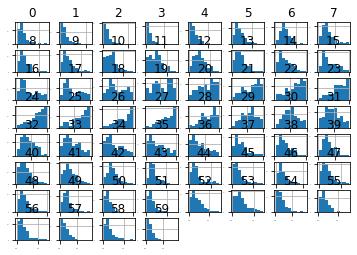

In [10]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
pyplot.show()

Podemos ver que há muitas distribuições gaussianas e talvez algumas exponenciais.
como distribuições para outros atributos.

Vamos dar uma olhada na mesma perspectiva dos dados usando gráficos de densidade.

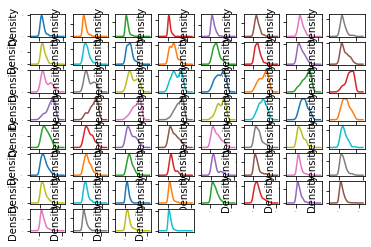

In [11]:
# density
dataset.plot(kind='density', subplots=True, layout=(8,8), sharex=False, legend=False,
fontsize=1)
pyplot.show()

Isso é útil, você pode ver que muitos dos atributos têm uma distribuição distorcida. Um poder
transformar como uma transformação Box-Cox que pode corrigir a distorção nas distribuições pode ser
útil.

É sempre bom olhar para gráficos de caixa e bigodes de atributos numéricos para ter uma ideia de
a propagação de valores.

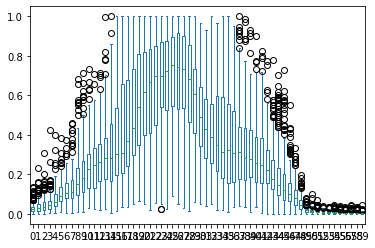

In [18]:
# box and whisker plots
dataset.plot.box()

pyplot.show()

Podemos ver que os atributos têm spreads bastante diferentes. Como as escalas são iguais,
pode sugerir algum benefício em padronizar os dados para modelagem para obter todas as médias alinhadas
acima

##### Visualizações de dados multimodais

Vamos visualizar as correlações entre os atributos.

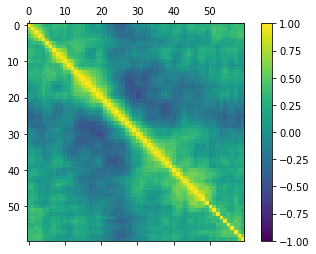

In [19]:
# correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
pyplot.show()

Parece que também há alguma estrutura na ordem dos atributos. O vermelho ao redor
a diagonal sugere que os atributos que estão próximos uns dos outros são geralmente mais correlacionados
um com o outro. As manchas azuis também sugerem alguma correlação negativa moderada quanto mais
os atributos estão distantes um do outro na ordenação. Isso faz sentido se a ordem do
Os atributos referem-se ao ângulo dos sensores para o chirp do sonar.

#### Conjunto de dados de validação

É uma boa ideia usar um conjunto de validação. Esta é uma amostra dos dados que mantemos
de volta de nossa análise e modelagem. Nós o usamos logo no final do nosso projeto para con rmar o
precisão do nosso modelo nal. É um teste de fumaça que podemos usar para ver se erramos e
nos dê confiança em nossas estimativas de precisão em dados não vistos. Usaremos 80% do conjunto de dados
para modelagem e reter 20% para validação.

In [20]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:60].astype(float)
Y = array[:,60]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

#### Avaliar algoritmos: linha de base

Não sabemos quais algoritmos se sairão bem neste conjunto de dados. A intuição sugere com base na distância
algoritmos como k-Nearest Neighbors e Support Vector Machines podem funcionar bem. vamos projetar
nosso arnês de teste. Usaremos validação cruzada de 10 vezes. O conjunto de dados não é muito pequeno e isso é
uma boa configuração de chicote de teste padrão. Avaliaremos algoritmos usando a precisão
métrica. Esta é uma métrica bruta que dará uma ideia rápida de quão correto é um determinado modelo. Mais
útil em problemas de classificação binária como este.

In [21]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

Vamos criar uma linha de base de desempenho neste problema e verificar no local uma série de diferentes
algoritmos. Vamos selecionar um conjunto de diferentes algoritmos capazes de trabalhar nesta classificação
problema. Os seis algoritmos selecionados incluem:

. Algoritmos Lineares: Regressão Logística (LR) e Análise Discriminante Linear (LDA).
. Algoritmos Não Lineares: Árvores de Classificação e Regressão (CART), Vetor de Suporte
Machines (SVM), Gaussian Naive Bayes (NB) e k-Nearest Neighbors (KNN).

In [22]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

Todos os algoritmos usam parâmetros de ajuste padrão. Vamos comparar os algoritmos. Vamos
exibir a média e o desvio padrão de precisão para cada algoritmo à medida que o calculamos e
coletar os resultados para uso posterior.

In [24]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.777574 (0.088423)
LDA: 0.778676 (0.093570)
KNN: 0.758824 (0.106417)
CART: 0.751471 (0.083517)
NB: 0.682721 (0.136040)
SVM: 0.765074 (0.087519)


A execução do exemplo fornece a saída abaixo. Os resultados sugerem que tanto a Logística
A regressão e os k-vizinhos mais próximos podem valer a pena um estudo mais aprofundado.

Estes são apenas valores médios de precisão. É sempre bom olhar para a distribuição de precisão
valores calculados em dobras de validação cruzada. Podemos fazer isso graficamente usando caixa e bigode
parcelas

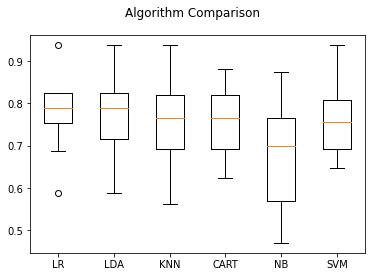

In [25]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Os resultados mostram uma distribuição apertada para KNN que é encorajadora, sugerindo baixa variância.
Os maus resultados para SVM são surpreendentes.

É possível que a distribuição variada dos atributos esteja afetando a precisão
de algoritmos como o SVM. Na próxima seção, repetiremos essa verificação aleatória com um
cópia do conjunto de dados de treinamento.

#### Avaliar algoritmos: padronizar dados

Suspeitamos que as diferentes distribuições dos dados brutos possam estar afetando negativamente a habilidade
de alguns dos algoritmos. Vamos avaliar os mesmos algoritmos com uma cópia padronizada do
conjunto de dados. É aqui que os dados são transformados de forma que cada atributo tenha um valor médio de zero
e um desvio padrão de um. Também precisamos evitar vazamento de dados quando transformamos o
dados. Uma boa forma de evitar vazamentos é usar pipelines que padronizam os dados e constroem o
modelo para cada dobra no chicote de teste de validação cruzada. Dessa forma, podemos obter uma estimativa justa
de como cada modelo com dados padronizados pode funcionar em dados não vistos.

In [27]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.754412 (0.067926)
ScaledLDA: 0.778676 (0.093570)
ScaledKNN: 0.808456 (0.107996)
ScaledCART: 0.733456 (0.116240)
ScaledNB: 0.682721 (0.136040)
ScaledSVM: 0.826103 (0.081814)


A execução do exemplo fornece os resultados listados abaixo. Podemos ver que KNN ainda está fazendo
bem, ainda melhor do que antes. Também podemos ver que a padronização dos dados elevou
a habilidade de SVM para ser o algoritmo mais preciso testado até agora.

Novamente, devemos traçar a distribuição das pontuações de precisão usando gráficos de caixa e bigode.

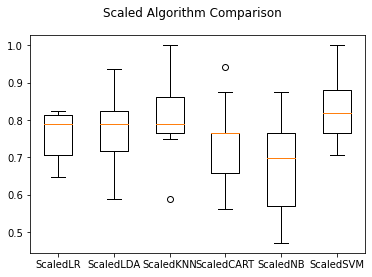

In [28]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Os resultados sugerem aprofundar os algoritmos SVM e KNN. É muito provável que
a configuração além do padrão pode render modelos ainda mais precisos.

#### Ajuste de Algoritmo

Nesta seção, investigamos o ajuste dos parâmetros para dois algoritmos que se mostram promissores de
a verificação pontual na seção anterior: KNN e SVM.

##### Ajuste KNN

Podemos começar ajustando o número de vizinhos para KNN. O número padrão de vizinhos
é 7. Abaixo, tentamos todos os valores ímpares de k de 1 a 21, cobrindo o valor padrão de 7. Cada valor de k
é avaliado usando validação cruzada de 10 vezes no conjunto de dados padronizado de treinamento.

In [30]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836029 using {'n_neighbors': 1}
0.836029 (0.079487) with: {'n_neighbors': 1}
0.813603 (0.088021) with: {'n_neighbors': 3}
0.814338 (0.096870) with: {'n_neighbors': 5}
0.777574 (0.120387) with: {'n_neighbors': 7}
0.730147 (0.099376) with: {'n_neighbors': 9}
0.741544 (0.073970) with: {'n_neighbors': 11}
0.710662 (0.105829) with: {'n_neighbors': 13}
0.723162 (0.080983) with: {'n_neighbors': 15}
0.698897 (0.072669) with: {'n_neighbors': 17}
0.710662 (0.091337) with: {'n_neighbors': 19}
0.698897 (0.091195) with: {'n_neighbors': 21}


Podemos imprimir a configuração que resultou na maior precisão, bem como a precisão
de todos os valores experimentados. Executando o exemplo, vemos os resultados abaixo.

Podemos ver que a configuração ótima é K=1. Isso é interessante, pois o algoritmo
faça previsões usando a instância mais semelhante apenas no conjunto de dados de treinamento.

##### Ajuste SVM

Podemos ajustar dois parâmetros-chave do algoritmo SVM, o valor de C (quanto relaxar o
margin) e o tipo de kernel. O padrão para SVM (a classe SVC) é usar o Radial
Kernel de função de base (RBF) com um valor C definido como 1,0. Como com KNN, vamos realizar uma grade
pesquisa usando validação cruzada de 10 vezes com uma cópia padronizada do conjunto de dados de treinamento. Vamos
tente vários tipos de kernel mais simples e valores C com menos viés e mais viés (menor que e
mais de 1,0 respectivamente).

In [31]:
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.850000 using {'C': 1.7, 'kernel': 'rbf'}
0.748529 (0.069953) with: {'C': 0.1, 'kernel': 'linear'}
0.582721 (0.127062) with: {'C': 0.1, 'kernel': 'poly'}
0.601103 (0.184435) with: {'C': 0.1, 'kernel': 'rbf'}
0.712868 (0.116579) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.754412 (0.082337) with: {'C': 0.3, 'kernel': 'linear'}
0.644118 (0.099873) with: {'C': 0.3, 'kernel': 'poly'}
0.742279 (0.081853) with: {'C': 0.3, 'kernel': 'rbf'}
0.748529 (0.069953) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.765809 (0.070336) with: {'C': 0.5, 'kernel': 'linear'}
0.704779 (0.098225) with: {'C': 0.5, 'kernel': 'poly'}
0.784559 (0.068922) with: {'C': 0.5, 'kernel': 'rbf'}
0.760662 (0.065632) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.759926 (0.083206) with: {'C': 0.7, 'kernel': 'linear'}
0.759559 (0.093807) with: {'C': 0.7, 'kernel': 'poly'}
0.814338 (0.059832) with: {'C': 0.7, 'kernel': 'rbf'}
0.761029 (0.079602) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.765441 (0.066964) with: {'C': 0.9, 'kernel': 'linear'

A execução do exemplo imprime a melhor configuração, a precisão, bem como as precisões
para todas as combinações de configuração.

Podemos ver que a configuração mais precisa foi SVM com um kernel RBF e um valor C
de 1,5. A precisão de 86,7470% é aparentemente melhor do que a KNN poderia alcançar.

#### Métodos de conjunto( Ensemble )

Outra maneira de melhorar o desempenho dos algoritmos nesse problema é usando
métodos de conjunto. Nesta seção, avaliaremos quatro métodos diferentes de aprendizado de máquina ensemble
algoritmos, dois métodos boosting e dois bagging:

. Métodos de Boosting: AdaBoost (AB) e Gradient Boosting (GBM).
. Métodos de ensacamento: Random Forests (RF) e Extra Trees (ET).

Usaremos o mesmo equipamento de teste de antes, validação cruzada de 10 vezes. Sem padronização de dados
é usado neste caso porque todos os quatro algoritmos de conjunto são baseados em árvores de decisão que são
menos sensível a distribuições de dados.

In [33]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.782721 (0.072445)
GBM: 0.808456 (0.130806)
RF: 0.826103 (0.066625)
ET: 0.819853 (0.052870)


Podemos ver que ambas as técnicas de aumento fornecem fortes pontuações de precisão na casa dos 80 (%)
com configurações padrão. Podemos plotar a distribuição de pontuações de precisão na cruz
dobras de validação.

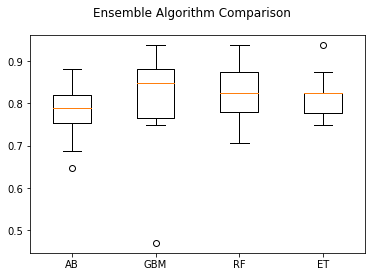

In [34]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

Os resultados sugerem que o GBM pode ser digno de um estudo mais aprofundado, com uma média forte e um spread
que se inclina para altos 90s (%) em precisão.

#### Finalizar modelo

O SVM se mostrou mais promissor como um modelo estável e de baixa complexidade para este problema. Em
Nesta seção, vamos finalizar o modelo treinando-o em todo o conjunto de dados de treinamento e fazer
previsões para o conjunto de dados de validação de espera para confirmar nossas conclusões. Uma parte dos resultados foi
que o SVM tem melhor desempenho quando o conjunto de dados é padronizado para que todos os atributos tenham uma média
valor de zero e um desvio padrão de um. Podemos calcular isso a partir de todo o treinamento
conjunto de dados e aplique a mesma transformação aos atributos de entrada do conjunto de dados de validação.

In [35]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=1.5)
model.fit(rescaledX, Y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8571428571428571
[[23  4]
 [ 2 13]]
              precision    recall  f1-score   support

           M       0.92      0.85      0.88        27
           R       0.76      0.87      0.81        15

    accuracy                           0.86        42
   macro avg       0.84      0.86      0.85        42
weighted avg       0.86      0.86      0.86        42



Podemos ver que alcançamos uma precisão de quase 86% no conjunto de dados de validação retido. A
pontuação que se aproxima de nossas expectativas estimadas acima durante o ajuste do SVM.

In [36]:
%reload_ext watermark
%watermark -gu "caiquemiranda" -iv

Github username: caiquemiranda

matplotlib: 3.5.2
numpy     : 1.23.0



### End.